# sentiment analysis

+ Our goal is to conduct sentiment analysis on the product review section
+ However, using sentiment analysis packages directly does not have a very good effect on handling the comment section
+ We choose to use sentiment dictionary matching for sentiment analysis
+ Specifically, we calculated the total number of emotional words in the comment section. If the number of positive words is greater than the number of negative words, it is considered a positive comment, and vice versa
+ After obtaining the results, we compared our method with the original comment type to test its effectiveness

In [1]:
import pandas as pd
import numpy as np
import jieba

Our final result is an xlsx file called "final comment.xlsx".

In [2]:
df = pd.read_excel('final comment.xlsx')

+ I downloaded some Chinese sentiment dictionaries from the Internet.
+ Initially, I wanted to read these files using read_csv, but unfortunately, the read_csv's sep parameter does not allow spaces.
+ It return an error: ValueError: Specified **\n** as separator or delimiter. This forces the python engine which does not accept a line terminator. Hence it is not allowed to use the line terminator as separator.
+ So I chose open() and readlines() instead

In [3]:
# Read various sentiment word lists

pos_comment = pd.DataFrame([line.strip() for line in open('Positive evaluation words (Chinese).txt', encoding='ANSI').readlines()])
neg_comment = pd.DataFrame([line.strip() for line in open('Negative evaluation words (Chinese).txt', encoding='ANSI').readlines()])
pos_emotion = pd.DataFrame([line.strip() for line in open('Positive sentiment words (Chinese).txt', encoding='ANSI').readlines()])
neg_emotion = pd.DataFrame([line.strip() for line in open('Negative sentiment words (Chinese).txt', encoding='ANSI').readlines()])



In [4]:
# Merge the positive word lists together
# axis = 0 means along rows

pos=pd.concat([pos_comment,pos_emotion],axis=0)

#  and negative word lists
neg=pd.concat([neg_comment,neg_emotion],axis=0)



+ Due to the lack of common words in product reviews in the sentiment dictionary, we manually collected some

In [5]:
# Collected common positive comments in the electronic shopping area

GoodComment=['巨爱','推荐','好用','满意','舒服','喜欢','买它','优惠',
             '很值','赞','精美','回购','漂亮','好看','不错','新款',
             '实惠','速度快','效果好','真好','继续买','非常好','很好',
             '质量不错','挺好的','继续购买','特别好','蛮好','一直在用','非常满意','特别好看']


BadComment=["极差","丢", "问题", "维权","不配","不好","垃圾","推脱",
            "受不了","偏差","脱线","差评","异味","敷衍","退款","没法",
            "md","下头","丢件","很差","更差","破损","贱","差评","开线","推卸责任",
            "一星","损害","破洞","拖","千万别","抵制","糟糕透顶","拖拖拉拉","一言难尽","不配","慢","莫名其妙","色差","太差","不好"]

In [6]:
# Determine whether these words are already in the positive word list
# If it's not there, add it in list new_pos

new_pos = []
for c in GoodComment:
    if c not in pos.values:
        new_pos.append(c)

new_neg = []
for c in BadComment:
    if c not in pos.values:
        new_neg.append(c)

In [7]:
# Add list new_pos to the list of positive words

pos = pd.concat([pos,pd.Series(new_pos)],axis=0).reset_index(drop=True)# Reset index

neg = pd.concat([neg,pd.Series(new_neg)],axis=0).reset_index(drop=True)

+ A better approach is to give different emotional words different weights, but this is beyond our ability 

In [8]:
# Add weights to sentiment words
# For simplicity, positive words are 1 and negative words are

pos.columns = ['review']
pos['weight'] = 1

neg.columns = ['review']
neg['weight'] = -1

In [9]:
# Merge positive and negative sentiment words together
pos_neg=pd.concat([pos,neg],axis=0)
pos_neg.shape

(8996, 2)

+ The stop_words was downloaded from the internet. We manually added some common stop words for comments

In [10]:
# Read the stop word list
stopwords = [line.strip() for line in open('stop_words.txt', encoding='UTF-8').readlines()] 

# Collected common stopwords in the electronic shopping area
stopwords = stopwords+[' ', '',',','，',' ️','❤️','🐻','\n','❤','🥺','😍','😘', '🥰','🙄', '😳','模板']


+ Jieba is a Chinese word segmentation package. Due to the lack of delimiters like English spaces in Chinese text, word segmentation of Chinese text must rely on the corresponding package.

In [11]:
# Use jieba to segment “content” to a new column
df['content_word'] = df['content'].apply(jieba.lcut)

# Remove words from the stop word list
df['content_word'] = df['content_word'].apply(lambda x: [i for i in x if i not in stopwords])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\zcx\AppData\Local\Temp\jieba.cache
Loading model cost 0.515 seconds.
Prefix dict has been built successfully.


In [12]:
df['content_word']

0       [巨爱, ️, 熊熊, 脸正, 手感, 好, 好, 挼, 正品, 满意, 购物, 物流, 四...
1       [不错, 好看, 鼻子, 有点, 歪, 摸, 舒服, 好, 可爱, jellycat, 已经...
2       [Jellycat, 巴, 塞罗, 熊太, 可爱, 拿到, 手, 已, 软萌, 模样, 击中...
3       [好, 不错, 熊, 这款, 巴, 塞罗, 熊, 真的, 好, 不错, 可爱, 好, 有趣,...
4       [可爱, 可爱, 可爱, 抱, 舒服, 经典, 款, 好看, 过时, 用料, 好, 不用, ...
                              ...                        
1036    [买, 一定, 慎重, 当时, 收到, 货, 异味, 以为, 快递, 盒, 味, 洗洗, 好...
1037    [说, 47cm, 需要, 两个, 人, 一个, 人, 一只, 手扯, 耳朵, 一只, 手扯...
1038    [垃圾, 店铺, 退货, 一直, 推脱, 一直, 不回, 消息, 服务态度, 极差, 真的,...
1039    [订单, 完成, 我连货, 收到, 这能, 完成, 告诉, 买, 东西, 现在, 店家, 发...
1040                        [手感, 不好, 分辨, 是不是, 正品, 小孩, 喜欢]
Name: content_word, Length: 1041, dtype: object

In [13]:
# Create a new dataframe for sentiment analysis
emotion_df = pd.DataFrame(columns=df.columns)

In [14]:
# Put each word segmentation result into a separate line
# Convenient matching of sentiment word lists

for index, row in df.iterrows():
    for word in row['content_word']:# In a row：
        new_row = row.copy() # Copy the current row's data in df
        new_row['content_word'] = word # add current word in ‘content_word’
        
        # add column ‘index_content’
        # indicate which original comment this word came from
        new_row['index_content'] = index

        # Add the current row to the dataframe for sentiment analysis
        emotion_df = pd.concat([emotion_df, pd.DataFrame([new_row])], ignore_index=True)

In [15]:
# Remove the original comment content column
emotion_df = emotion_df.drop(columns='content')

In [16]:
emotion_df

,Unnamed: 0,nickname,plusAvailable,creationTime,location,Stars,class,content_word,index_content
0,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,巨爱,0.0
1,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,️,0.0
2,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,熊熊,0.0
3,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,脸正,0.0
4,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,手感,0.0
...,...,...,...,...,...,...,...,...,...
16164,1040,7***s,103,2020-01-02 19:02:54,Unknown,1,neg,分辨,1040.0
16165,1040,7***s,103,2020-01-02 19:02:54,Unknown,1,neg,是不是,1040.0
16166,1040,7***s,103,2020-01-02 19:02:54,Unknown,1,neg,正品,1040.0
16167,1040,7***s,103,2020-01-02 19:02:54,Unknown,1,neg,小孩,1040.0


In [17]:
# Match and merge sentiment analysis dataframe and sentiment words together
# Matching based on "content_word" and "review"

review_type=pd.merge(emotion_df,pos_neg,how='left',left_on='content_word',right_on='review')
review_type.shape

(17230, 11)

In [18]:
review_type.head(50)

,Unnamed: 0,nickname,plusAvailable,creationTime,location,Stars,class,content_word,index_content,review,weight
0,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,巨爱,0.0,巨爱,1.0
1,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,️,0.0,NaN,NaN
2,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,熊熊,0.0,NaN,NaN
3,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,脸正,0.0,NaN,NaN
4,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,手感,0.0,NaN,NaN
5,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,好,0.0,好,1.0
6,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,好,0.0,好,1.0
7,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,好,0.0,好,1.0
8,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,好,0.0,好,1.0
9,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,挼,0.0,NaN,NaN


In [19]:
# After matching, can delete one of the columns
# All unmatched words are non-emotional words and are given a weight of 0.

review_type=review_type.drop(['review'],axis=1)
review_type=review_type.replace(np.nan,0)
review_type.head()

,Unnamed: 0,nickname,plusAvailable,creationTime,location,Stars,class,content_word,index_content,weight
0,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,巨爱,0.0,1.0
1,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,️,0.0,0.0
2,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,熊熊,0.0,0.0
3,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,脸正,0.0,0.0
4,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,手感,0.0,0.0


In [20]:
# Find each comment through "index_content"
# The final score is sum of weight 
emotion_value=review_type.groupby('index_content',as_index=False)['weight'].sum()
emotion_value.head()

,index_content,weight
0,0.0,5.0
1,1.0,7.0
2,2.0,8.0
3,3.0,20.0
4,4.0,12.0


In [21]:
# Create a copy of "emotion_value" to filter sentiment
content_emotion_value=emotion_value.copy()

# We only evaluate the scores that are not equal to 0
content_emotion_value=content_emotion_value[content_emotion_value['weight']!=0]

# Set sentiment
# Score > 0 is positive, and a score < 0 is negative
content_emotion_value['pred_type']=''
content_emotion_value.loc[content_emotion_value['weight'] > 0, 'pred_type'] = 'pos'
content_emotion_value.loc[content_emotion_value['weight'] < 0, 'pred_type'] = 'neg'

content_emotion_value.shape
content_emotion_value.head()


,index_content,weight,pred_type
0,0.0,5.0,pos
1,1.0,7.0,pos
2,2.0,8.0,pos
3,3.0,20.0,pos
4,4.0,12.0,pos


In [22]:
# After calculation, weight can be deleted
content_emotion_value=content_emotion_value.drop(['weight'],axis=1)

In [23]:
content_emotion_value

,index_content,pred_type
0,0.0,pos
1,1.0,pos
2,2.0,pos
3,3.0,pos
4,4.0,pos
...,...,...
1036,1036.0,neg
1037,1037.0,pos
1038,1038.0,neg
1039,1039.0,neg


In [24]:
# Match and merge sentiment results to the vocabulary "review_type"
# Matching based on "index_content" 

review_type=pd.merge(review_type,content_emotion_value,how='left',left_on='index_content',right_on='index_content')

review_type.shape
review_type.head()



,Unnamed: 0,nickname,plusAvailable,creationTime,location,Stars,class,content_word,index_content,weight,pred_type
0,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,巨爱,0.0,1.0,pos
1,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,️,0.0,0.0,pos
2,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,熊熊,0.0,0.0,pos
3,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,脸正,0.0,0.0,pos
4,0,割***咩,201,2024-11-06 21:43:45,山东,5,pos,手感,0.0,0.0,pos


In [25]:
# Creating a confusion matrix

# Choose data
cate=['index_content','class','pred_type']

# Because there are multiple lines for the same comment, only the first one is kept.
data_type=review_type[cate].drop_duplicates()


confusion_matrix=pd.crosstab(data_type['class'],data_type['pred_type'])
confusion_matrix

pred_type,neg,pos
class,,
neg,29,5
pos,12,946


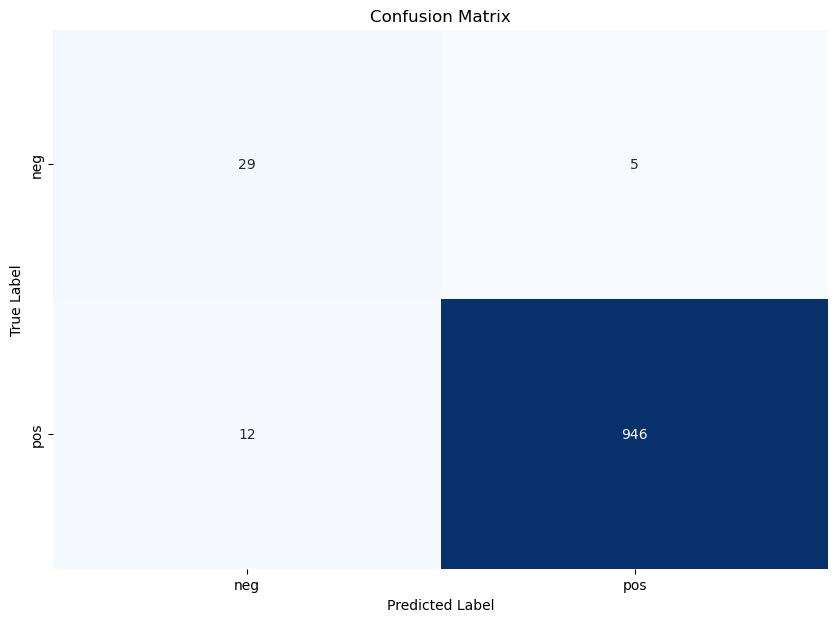

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization
plt.figure(figsize=(10, 7))  # Set size

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False) 

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

# TF-IDF

+ TF-IDF (Term Frequency Across Document Frequency) is a commonly used weighting technique.
+ Its purpose is to reflect the **importance** of a word to one of the documents in a document collection or corpus.
+ The TF-IDF value consists of two parts: word frequency (TF) and inverse document frequency (IDF)
+ Term Frequency (TF):
    Word frequency refers to the number of times a word appears in a document. This number is usually standardized (usually word frequency divided by the total number of words in the document) to prevent it from leaning towards longer documents.
+ Inverse Document Frequency (IDF):
    The inverse document frequency is a measure of the universal importance of a word. Its calculation is to divide the total number of documents in the corpus by the number of documents containing the word, and then take the logarithm of the result. The IDF value of a word decreases as its frequency of occurrence in the corpus increases
+ Afterwards, we drew word clouds for both positive and negative comments separately


In [27]:
# Calculate the TF-IDF value

# Connect the word segmentation results with spaces 
# to facilitate the subsequent word vectorization of the text

df['cutword'] = df['content_word'].apply(lambda x : ' '.join(x))
df['cutword'] 

0       巨爱 ️ 熊熊 脸正 手感 好 好 挼 正品 满意 购物 物流 四百多 熊 舍得 发 sf ...
1       不错 好看 鼻子 有点 歪 摸 舒服 好 可爱 jellycat 已经 买 玩具 送 防尘 ...
2       Jellycat 巴 塞罗 熊太 可爱 拿到 手 已 软萌 模样 击中 毛绒绒 质感 超级 ...
3       好 不错 熊 这款 巴 塞罗 熊 真的 好 不错 可爱 好 有趣 好 味道 好 喜欢 好 喜...
4       可爱 可爱 可爱 抱 舒服 经典 款 好看 过时 用料 好 不用 担心 过敏 好看 好看 好...
                              ...                        
1036    买 一定 慎重 当时 收到 货 异味 以为 快递 盒 味 洗洗 好 一点 洗衣 液 水 黑 ...
1037    说 47cm 需要 两个 人 一个 人 一只 手扯 耳朵 一只 手扯 腿 用力 扯直 47 ...
1038    垃圾 店铺 退货 一直 推脱 一直 不回 消息 服务态度 极差 真的 受不了 这种 店铺 没...
1039    订单 完成 我连货 收到 这能 完成 告诉 买 东西 现在 店家 发货 快递 弄 丢 问题 ...
1040                                手感 不好 分辨 是不是 正品 小孩 喜欢
Name: cutword, Length: 1041, dtype: object

In [28]:
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
 


# Create an instance of TfidfVectorizer
# It will be used to convert text into TF-IDF features
tf_vectorizer = TfidfVectorizer()

# Fit the TfidfVectorizer model to the 'cutword' column and transform the text data into TF-IDF feature vectors
# The 'fit_transform' method learns the vocabulary and idf vectors from the training data and then applies this transformation to the data
tfidf_model = tf_vectorizer.fit_transform(df.cutword)

# Retrieve the feature names (vocabulary) from the TfidfVectorizer instance
# This will give us the names of the columns in the transformed data, which correspond to the unique words in the text data
feature_names = tf_vectorizer.get_feature_names_out()

# Get the TF-IDF value of each word
tfidf_scores = tfidf_model.toarray().sum(axis=0).astype(float)

In [29]:
type(tfidf_scores)

numpy.ndarray

In [30]:
# View Results
data1 = {'word': feature_names,
        'tfidf': tfidf_scores}
df1 = pd.DataFrame(data1).sort_values(by="tfidf" ,ascending=False,ignore_index=True) 
df1.head(20)

,word,tfidf
0,可爱,89.371772
1,喜欢,74.062105
2,超级,50.418185
3,小熊,41.583943
4,舒服,41.047036
5,手感,38.354901
6,特别,38.242307
7,真的,30.630078
8,不错,30.292009
9,熊熊,27.388564


In [31]:
# Creating dict "word_tfidf" to Create word_cloud

word_tfidf = dict(zip(feature_names, tfidf_scores))

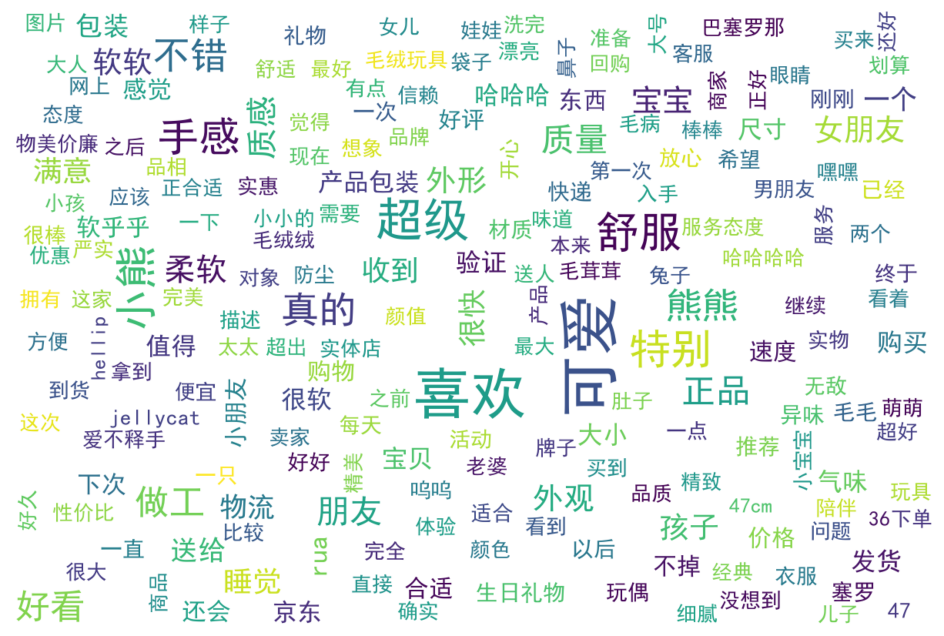

In [32]:
from wordcloud import WordCloud

# Creating word_cloud with text as argument in .generate() method
# Add the Chinese font path
word_cloud = WordCloud(font_path="C:/Windows/Fonts/simhei.ttf",width = 1200, height = 800,
                       collocations = False, 
                       background_color = 'white',
                       min_font_size = 5, max_font_size = 80).generate_from_frequencies(word_tfidf)


## Set the size
fig = plt.figure(figsize = (12, 8))

## This is to plot the figure
plt.imshow(word_cloud, interpolation = 'hamming')
plt.axis('off')

# Save the figure
fig.savefig('Fig.pdf', format='pdf', dpi=300, bbox_inches='tight')

(-0.5, 999.5, 999.5, -0.5)

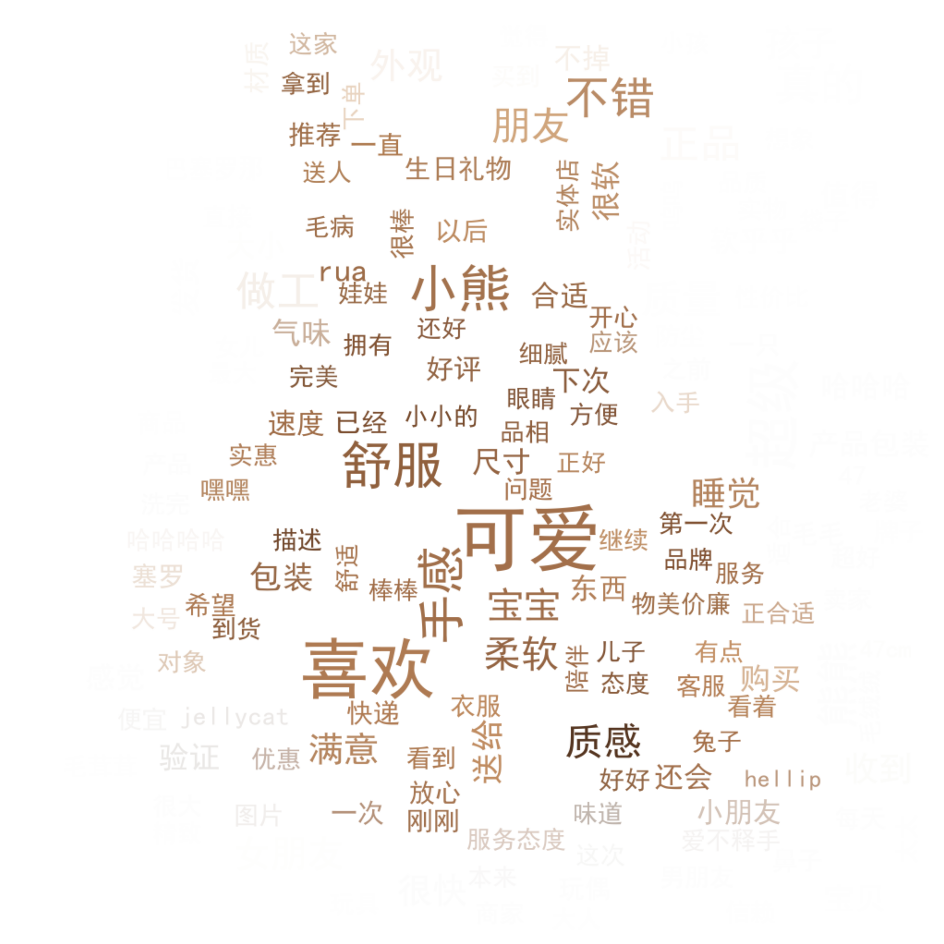

In [33]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

mask = np.array(Image.open("bear.jpg"))


word_cloud1 = WordCloud(font_path="C:/Windows/Fonts/simhei.ttf",width = 1000, height = 1000,
                       collocations = False, 
                       background_color = 'white',
                       min_font_size = 5, max_font_size = 80).generate_from_frequencies(word_tfidf)
## Set the size
fig = plt.figure(figsize = (12, 12))

# font color matching the masked image
img_colors = ImageColorGenerator(mask)
word_cloud1.recolor(color_func = img_colors)

## This is to plot the figure
plt.imshow(word_cloud1, interpolation = 'hamming')
plt.axis('off')

In [41]:
df['class']

0       pos
1       pos
2       pos
3       pos
4       pos
       ... 
1036    neg
1037    neg
1038    neg
1039    neg
1040    neg
Name: class, Length: 1041, dtype: object

In [50]:
aaaa = df.loc[df['class'] == 'pos']
bbbb = df.loc[df['class'] == 'neg']

In [55]:
tfidf_model = tf_vectorizer.fit_transform(bbbb.cutword)

# Retrieve the feature names (vocabulary) from the TfidfVectorizer instance
# This will give us the names of the columns in the transformed data, which correspond to the unique words in the text data
feature_names = tf_vectorizer.get_feature_names_out()

# Get the TF-IDF value of each word
tfidf_scores = tfidf_model.toarray().sum(axis=0).astype(float)
word_tfidf = dict(zip(feature_names, tfidf_scores))

In [91]:
# View Results
data1 = {'word': feature_names,
        'tfidf': tfidf_scores}
df1 = pd.DataFrame(data1).sort_values(by="tfidf" ,ascending=False,ignore_index=True) 
df1.head(20)

,word,tfidf
0,客服,1.745522
1,快递,1.674146
2,差评,1.494893
3,商家,1.430025
4,垃圾,1.345663
5,卖家,1.306173
6,一直,1.300464
7,问题,1.294678
8,商品,1.252218
9,真的,1.220674


(-0.5, 1199.5, 799.5, -0.5)

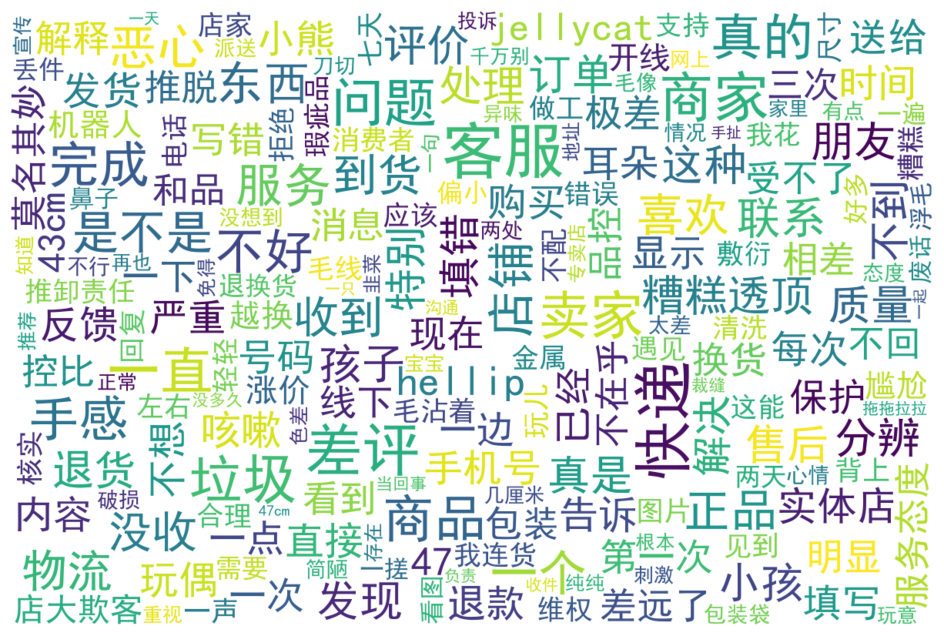

In [60]:
# Creating word_cloud with text as argument in .generate() method
# Add the Chinese font path
word_cloud = WordCloud(font_path="C:/Windows/Fonts/simhei.ttf",width = 1200, height = 800,
                       collocations = False, 
                       background_color = 'white',
                       min_font_size = 5, max_font_size = 80).generate_from_frequencies(word_tfidf)


## Set the size
fig = plt.figure(figsize = (12, 8))

## This is to plot the figure
plt.imshow(word_cloud, interpolation = 'hamming')
plt.axis('off')


(-0.5, 939.5, 1199.5, -0.5)

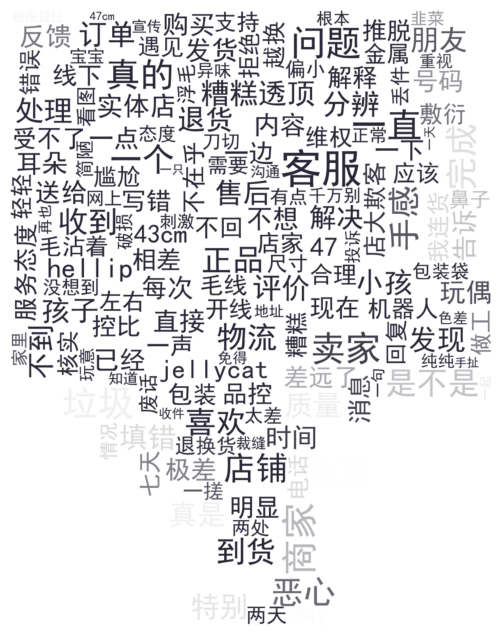

In [90]:
mask = np.array(Image.open("bad.jpg"))


word_cloud1 = WordCloud(font_path="C:/Windows/Fonts/simhei.ttf",width = 940, height = 1200,
                       collocations = False, 
                       background_color = 'white',
                       min_font_size = 5, max_font_size = 80).generate_from_frequencies(word_tfidf)
## Set the size
fig = plt.figure(figsize = (10, 8))

# font color matching the masked image
img_colors = ImageColorGenerator(mask)
word_cloud1.recolor(color_func = img_colors)

## This is to plot the figure
plt.imshow(word_cloud1, interpolation = 'hamming')
plt.axis('off')

(-0.5, 939.5, 1199.5, -0.5)

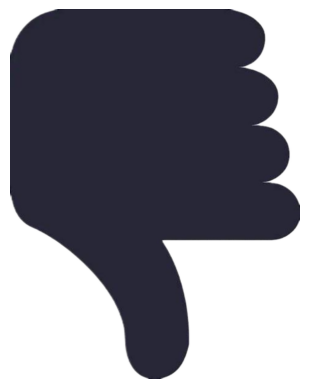

In [87]:
plt.imshow(mask)
plt.axis('off')